# Perceptron Implementation

* R. Connor Franckowiak 
* Jan. 31, 2021

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import Perceptron
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd

## Implement the perceptron learning algorithm. 

### Notes:
- Shuffle the data each epoch.
- Implemented way to create a random train/test split
- Use Stochastic/On-line training updates
- Implemented stopping criteria

In [26]:
class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, Deterministic=None, shuffle=True):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            Deterministic (int): a set number of epochs to train on if not None
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
                SHUFFLE for evaluation / debug datasets.
        """
        self.lr = lr
        self.Deterministic = Deterministic
        self.shuffle = shuffle
        self.epoch_accuracies = []

    def fit(self, X, y, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
                weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.weights = self.initialize_weights(X.shape[1]) if initial_weights is None else initial_weights
        
        n = X.shape[0]                      #Number of training instances
        X_ = np.column_stack((X,np.array([1 for i in range(n)])))    # Add bias input column
        self.epoch_accuracies = []                 # Keep track of accuries to track the amount of change
        num_iter = 0
        while True:
            if self.shuffle:
                self._shuffle_data(X_,y)
            for i in range(n):
                net = np.dot(X_[i,:], self.weights)
                #See if neuron fires
                output = 0 if net <= 0 else 1
                #Modify weights after each training instance
                if output != y[i]:
                    self.weights = self.weights + self.lr * (y[i] - output) * X_[i,:]
            # Break after so many epochs if deterministic
            num_iter += 1
            if self.Deterministic and num_iter >= self.Deterministic:
                break
            # After each epoch, check the score
            # Stopping critera is if there is no change of more than 5% in the last 5 epochs,
            # then stop the training.
            self.epoch_accuracies.append(self.score(X,y))
            if len(self.epoch_accuracies) > 5:
                self.epoch_accuracies.pop(0)
            if not self.Deterministic and len(self.epoch_accuracies) == 5 and (np.max(self.epoch_accuracies) - np.min(self.epoch_accuracies)) <= .05:
                self.epochs = num_iter
                break
            

        return self

    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        n = X.shape[0]                      # Number of training instances
        X_ = np.column_stack((X,np.array([1 for i in range(n)])))    # Add bias input column
        y = []
        # Iterate through each data instance
        for i in range(n):
            net = np.sum(X_[i,:] * self.weights)
            #See if neuron fires
            output = 0 if net < 0 else 1
            y.append(output)
        return np.array(y)
        

    def initialize_weights(self, n):
        """ Initialize weights for perceptron. Don't forget the bias!
        Args:
            n (int): number of features of the inputted data
        Returns:
            array, shape(n+1,) of weights, including bias weight
        """
        return np.array([0 for i in range(n+1)])

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        n = X.shape[0]   #Number of data points
        p = self.predict(X)    # Predicted outputs
        num_incorrect = np.count_nonzero(y-p)   #if target and prediction differ, result in nonzero.
        return (n-num_incorrect)/n

    def _shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        indices = [i for i in range(X.shape[0])]
        np.random.shuffle(indices)
        X = X[indices,:]
        y = y[indices]
        

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

## Debug 

Debug model by running it on the [debug dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)

Parameters:

Learning Rate = 0.1\
Deterministic = 10\
Shuffle = False\
Initial Weights = All zeros

In [27]:
# Load debug data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep2nonorigin.arff

data = arff.loadarff('linsep2nonorigin.arff')
df = pd.DataFrame(data[0])
df.head()
debug = np.array(df)

X = debug[:,:-1]
y = debug[:,-1]
y[y == b'1'] = int(1)
y[y == b'0'] = int(0)

# Train on debug data
tron = PerceptronClassifier(0.1,10,False)
tron.fit(X,y)

# Check accuracy and weights
print("\nAccuracy: " + str(tron.score(X,y)))
print("Weights: " + str(tron.get_weights()))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   1824      0 --:--:-- --:--:-- --:--:--  1824

Accuracy: 0.875
Weights: [-0.23000000000000004 0.1799999999999999 -0.1]


## Evaluation

Evaluate model based on it's performance on the [evaluation dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [28]:
# Load evaluation data
# Download file with curl
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff --output data_banknote_authentication.arff

data = arff.loadarff('data_banknote_authentication.arff')
df = pd.DataFrame(data[0])
df.head()
eval = np.array(df)

X = eval[:,:-1]
y = eval[:,-1]
y[y == b'1'] = int(1)
y[y == b'0'] = int(0)

# Train on debug data
eval_tron = PerceptronClassifier(0.1,10,False)
eval_tron.fit(X,y)

# Check accuracy and weights
print("\nAccuracy: " + str(eval_tron.score(X,y)))
print("Weights: \n" + str(eval_tron.get_weights()))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   342k      0 --:--:-- --:--:-- --:--:--  342k

Accuracy: 0.9876093294460642
Weights: 
[-3.80657242 -2.8408210000000014 -3.0719334000000034 -1.4003906000000004
 4.899999999999999]


## Create 2 datasets

- Both with 8 instances using 2 real valued inputs (ranging between -1 and 1) with 4 instances from each class. 
- One data set should be linearly separable and the other not.
- Graph each dataset

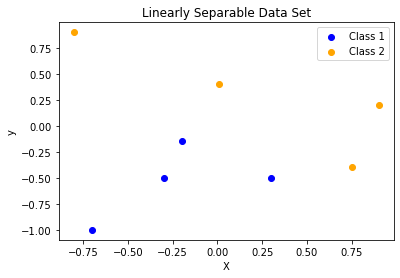

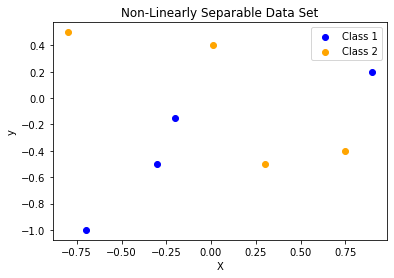

In [29]:
# Create 2 datasets
separable = np.array([[-.2,-.15,0],[-.3,-.5,0],[.3,-.5,0],[-.7,-1,0],[.75,-.4,1],[.9,.2,1],[-.8,.9,1],[.01,.4,1]])
plt.scatter(separable[:4,0],separable[:4,1],c='blue',marker='o',label="Class 1")
plt.scatter(separable[4:,0],separable[4:,1],c='orange',marker='o',label="Class 2")
plt.legend(loc="best")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linearly Separable Data Set")
plt.show()

nonseparable = np.array([[-.2,-.15,0],[.9,.2,0],[-.3,-.5,0],[-.7,-1,0],[.75,-.4,1],[.3,-.5,1],[-.8,.5,1],[.01,.4,1]])
plt.scatter(nonseparable[:4,0],nonseparable[:4,1],c='blue',marker='o',label="Class 1")
plt.scatter(nonseparable[4:,0],nonseparable[4:,1],c='orange',marker='o',label="Class 2")
plt.legend(loc="best")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Non-Linearly Separable Data Set")
plt.show()

## Train on both sets with perceptron code.

- Use a couple different learning rates.


In [30]:
# Train on each dataset

rates = [.1*i for i in range(1,11)]

# Separable
num_epochs = []
for lr in rates:
    sep = PerceptronClassifier(lr)
    # Random initialized weights
    w = np.random.random(3)
    sep.fit(separable[:,:-1],separable[:,-1],w)
    num_epochs.append(sep.epochs)
    w = sep.get_weights()
print("Separable\nLearning Rate vs. Number of Epochs needed to converge:")
print(np.row_stack((np.array(rates),num_epochs)))

#Non-Separable
num_epochs = []
for lr in rates:
    nonsep = PerceptronClassifier(lr)
    # Random initialized weights
    w = np.random.random(3)
    nonsep.fit(nonseparable[:,:-1],nonseparable[:,-1],w)
    num_epochs.append(nonsep.epochs)
    w = sep.get_weights()
print("\nNon-Separable\nLearning Rate vs. Number of Epochs needed to converge:")
print(np.row_stack((np.array(rates),num_epochs)))

Separable
Learning Rate vs. Number of Epochs needed to converge:
[[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 6.   5.   7.   6.   6.   6.   9.   5.  10.   8. ]]

Non-Separable
Learning Rate vs. Number of Epochs needed to converge:
[[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
 [ 5.  13.   9.   5.   6.   6.   5.   9.   5.   5. ]]


*Discussion of the effect of learning rate, including how many epochs are completed before stopping.*


### Discussion: 

For the separable set, it appears, generally, that the most epochs required to converge were in the beginning-middle of the possible values of learning rate, namely between 0.2 and 0.7.  This is indicative that the higher the learning rate, the faster the algorithm "learns" the data and is able to best fit the data.

On the other hand, for the non-separable set, the algorithm performs best with higher learning rates (it seems that the higher the learning rate, the better it performs generally, in terms of efficiency of convergence).  This makes sense, since a lower learning value learns slower, resulting in more time necessary to approach a reasonable solution (especially considering the absence of a true decision line).  As the learning rates get higher, the algorithm can more quickly approach the solution, and although more responsive to outliers, the usage of shuffled data between epochs aids with preventing oscillatory tendencies.

## Graph the instances and decision line for the two cases above (with LR=.1)

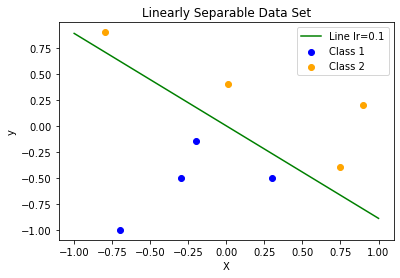

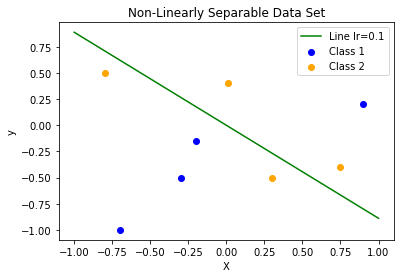

In [31]:
# Graph decision line

#Separable
num_epochs = []
domain = np.linspace(-1,1,200)
sep = PerceptronClassifier(.1)
sep.fit(separable[:,:-1],separable[:,-1])
num_epochs.append(sep.epochs)
w = sep.get_weights()
y = lambda x: (-w[2]-w[0]*x)/w[1]
plt.plot(domain, y(domain),"g-",label="Line lr=" + str(.1))

plt.scatter(separable[:4,0],separable[:4,1],c='blue',marker='o',label="Class 1")
plt.scatter(separable[4:,0],separable[4:,1],c='orange',marker='o',label="Class 2")
plt.legend(loc="best")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linearly Separable Data Set")
plt.show()

#Non-Separable
nonsep = PerceptronClassifier(.1)
nonsep.fit(nonseparable[:,:-1],nonseparable[:,-1])
num_epochs.append(nonsep.epochs)
w = sep.get_weights()
y = lambda x: (-w[2]-w[0]*x)/w[1]
plt.plot(domain, y(domain),"g-",label="Line lr=" + str(.1))

plt.scatter(nonseparable[:4,0],nonseparable[:4,1],c='blue',marker='o',label="Class 1")
plt.scatter(nonseparable[4:,0],nonseparable[4:,1],c='orange',marker='o',label="Class 2")
plt.legend(loc="best")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Non-Linearly Separable Data Set")
plt.show()

## Use perceptron code to learn this version of the [voting data set](https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff).

This particular set is an edited version of the standard voting set, where I have replaced all the “don’t know” values with the most common value for the particular attribute.  

### Create a table that reports the final training and test set accuracy and the number of epochs for each trial.

- Try it five times with different random 70/30 splits, splitting using my own implementation
- Report the average of these values for the 5 trials in the table.  


*- As a rough sanity check, typical Perceptron test accuracies for the voting data set are 90%-98%.*


In [32]:
# Create table any way you like
# Download file with curl
!curl https://raw.githubusercontent.com/rmorain/CS472-1/master/datasets/perceptron/voting-dataset.arff --output voting-dataset.arff

data = arff.loadarff('voting-dataset.arff')
df = pd.DataFrame(data[0])
df.head()
votes = np.array(df)

votes[votes == b'n'] = 0
votes[votes == b'y'] = 1
votes[votes == b'democrat'] = 0
votes[votes == b'republican'] = 1
misclassification = []

results = []
weights = []
for i in range(5):
    tmp = []
    tmp.append(i+1)
    
    # Randomize and Split Data
    n = votes.shape[0]
    indices = [i for i in range(n)]
    np.random.shuffle(indices)
    votes_ = votes[indices,:]
    
    X_train = votes_[:int(n*.7)+1,:-1]
    y_train = votes_[:int(n*.7)+1,-1]
    X_test = votes_[int(n*.7)+1:,:-1]
    y_test = votes_[int(n*.7)+1:,-1]
    
    # Train and evaluate
    vote_tron = PerceptronClassifier(.2)
    vote_tron.fit(X_train, y_train)
    misclassification.append(1-np.array(vote_tron.epoch_accuracies))
    tmp.append(vote_tron.score(X_train, y_train))
    tmp.append(vote_tron.score(X_test, y_test))
    tmp.append(vote_tron.epochs)
    weights.append(vote_tron.get_weights())
    results.append(tmp)
res = np.array(results)
avg = ["Avgs", np.mean(res[:,1]),np.mean(res[:,2]),np.mean(res[:,3])]
results.append(np.array(avg))
results.insert(0,["Trial","Training Accuracy","Test Accuracy", "Number of Epochs"])
from tabulate import tabulate
print(tabulate(results))
print("\nWeights:")
for w in weights:
    print([round(elem, 2) for elem in w])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43825  100 43825    0     0   312k      0 --:--:-- --:--:-- --:--:--  312k
-----  ------------------  ------------------  ----------------
Trial  Training Accuracy   Test Accuracy       Number of Epochs
1      0.9597523219814241  0.9420289855072463  5
2      0.9009287925696594  0.9057971014492754  13
3      0.9659442724458205  0.9927536231884058  5
4      0.9628482972136223  0.9710144927536232  5
5      0.9566563467492261  0.9130434782608695  5
Avgs   0.9492260061919504  0.944927536231884   6.6
-----  ------------------  ------------------  ----------------

Weights:
[-0.2, 0.0, -1.0, 2.2, 0.6, -0.4, -0.2, 0.6, -0.8, 0.4, -1.6, 0.2, -0.2, 0.0, -0.4, 1.0, -1.0]
[1.0, -0.6, -1.0, 4.2, 0.8, -0.2, 1.2, 0.2, -1.4, 1.6, -1.6, 0.4, -0.2, -0.0, -1.0, 0.4, -1.6]
[0.0, -0.2, -1.2, 2.8, 0.4, -0.4, 0.8, 0.6, -0.4, 0.4, -1.2, 0.0, 0.2, -0.

### By looking at the weights, explanation of what the model has learned and how the individual input features affect the result. Which specific features are most critical for the voting task, and which are least critical? 


By Analyzing the weights, we see that among the 5 trials, the weights of each feature are fairly consistent, which indicates a precise learning of the data (and fairly accurate, considering the accuracy ratings).  Overall, the features with the most impact are the Physician Fee Freeze, and to a lesser extent the Adoption of Budget Resolution, Aid to Nicaraguan Contras, MX Missiles, and Synfuels Corporation Cutback.  Among those that affected the least include Eduation Spending, Superfund Right to Sue, Crime, and Handicapped Infants.  

### Make a graph of the average misclassification rate vs epochs (0th – final epoch).

- Average the misclassification rate for the training set across the 5 trials (not across 5 epochs).


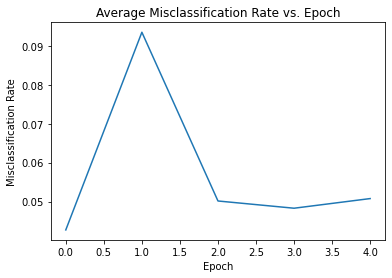

In [33]:
# Graph here
misclassification = np.array(misclassification)
misclassification = np.mean(misclassification,axis=1)
    
def plot_misclassification(avg_misclassification_rate):
    """
        Plots the average misclassification rate
    Args:
        avg_misclassification_rate (array-like): A 1D array or list
    """
    plt.plot(np.arange(len(avg_misclassification_rate)), avg_misclassification_rate)
    plt.title("Average Misclassification Rate vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Misclassification Rate")
    plt.show()

plot_misclassification(misclassification)


# TODO: Use SKLearn to implement the Perceptron algorithm, answering the following questions

## Use the perceptron algorithm from the [scikit-learn toolkit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) to learn the voting task above and also one other data set of my choice.

- Report and compare results.
- Try out some of the hyper-parameters that scikit-learn makes available on my own perceptron.

In [1]:
# Load sklearn perceptron

# Train on voting dataset

*Report comparison*

## Use the perceptron rule to learn the [iris task](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) or some other task with more than two possible output values. 

Note that the [iris data](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff) set has 3 output classes, and a perceptron node only has two possible outputs.  Possibly could implement either of the two most common ways to deal with this. For testing, just execute the novel instance on each model and combine the overall results to see which output class wins.